# Binary Asteroid

This example examine the dynamics of a probe in an asteroid binary system.
First, Lissajous orbits are defined in the RTBP.

Then we construct manifold that should allow going from Halo to Halo orbits.

Finally, we asses the possibility of observing both asteroids from a selected vantage point orbit.

Before starting, let's import the usual modules.

In [1]:
import r3bpy
from r3bpy.main import Problem, Manifold
from r3bpy.orbits import print_info

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [10, 10]

## RTBP definition

We now defined the restricted three body problem parameters. Consider the case of the asteroid binary system 1999 KW4.

In [3]:
rb = 2540.0    # Distance between primaries, m

m1 = 2.353 * 1e12  # primary (Alpha) is almost a sphere

# Spherical model for representing Alpha (primary) 1999 KW4
# Normalize by rb (distance among primaries)
rs = 1.3 * 1e3 / rb

m2 = 0.135 * 1e12  # secondary (Beta) is an ellipsoid
# Ellipsoid representing Beta model (secondary) 1999 KW4
# Normalize by rb (distance among primaries)
alpha = (570/2.) / rb
beta = (455/2.) / rb
gamma = (343/2.) / rb

In [4]:
problem = Problem(m1, m2, rb)
mu_ratio = problem.get_mu_ratio()
DU = problem.get_distance_normalisation()
TU = problem.get_time_normalisation()
print("mu_ratio=", mu_ratio)
print("time normalisation=", TU)
print("distance normalisation=", DU)

mu_ratio= 0.05426045016077171
time normalisation= 0.0811568882749299
distance normalisation= 2540.0


Let's have a model representation of the system. 
For convenience, we define a plot function.

In [5]:
from r3bpy.visu.plot_object import Ellipsoid

def plot_binary_system(ax, mu):
    e1 = Ellipsoid([rs, rs, rs], [-mu, 0, 0])
    e2 = Ellipsoid([alpha, beta, gamma], [1-mu, 0, 0])    
    if ax:
        e1.plot(ax,color='grey')
        e2.plot(ax,color='grey')
    return e1, e2

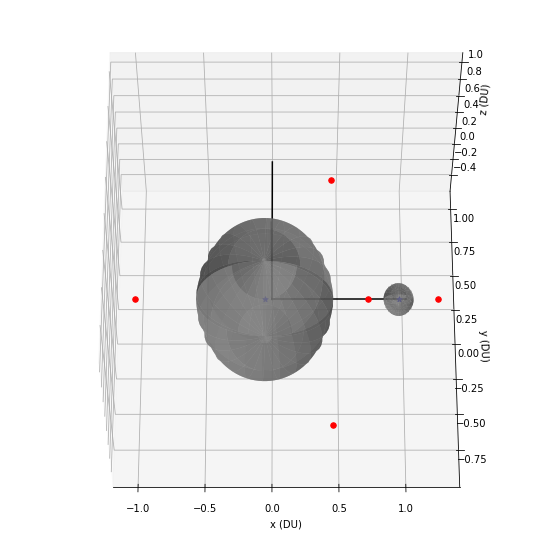

In [6]:
from r3bpy.visu import plot_trajectory, plot_system

ax, fig = r3bpy.visu.init_figure(False)
plot_system(problem, is2d=False, withAxes=True, ax=ax)
plot_binary_system(ax, mu_ratio)
ax.view_init(elev=60., azim=270)
plt.show()

## Halo orbit

We would now compute and plot the Libration points of this system, as well as a Halo orbit. The purpose would be to evaluate the possibility of a vantage point from the Halo orbit on both asteroids.

In [7]:
libration_point = problem.get_libration_point_info(r3bpy.main.L1)

In [8]:
from r3bpy.orbits import HaloOrbit

# amplitude of the lissajous orbit
Ax = 70.0 / rb
halo = HaloOrbit(libration_point)
halo_orbit = halo.find_orbit(Ax)

In [9]:
orbit_period = halo_orbit.period
print('Halo period: {} h'.format(halo_orbit.period * TU / 3600.))
print('Orbit amplitudes: ', halo_orbit.Ax, halo_orbit.Ay, halo_orbit.Az)

Halo period: 5.746603828703515e-05 h
Orbit amplitudes:  0.021369635099567078 0.0 0.027559055118110236


We can construct a family of Halo orbits around Libration point L1

In [10]:
AxInit = 70.0 / DU
AxFinal = 700.0 / DU
AxStep = 5.0 / DU
ax_grid = np.arange(AxInit, AxFinal, AxStep)


def plot_halo(halo_orbit, color, ax):
    orbit_period = halo_orbit.period
    _, xyz = halo_orbit.propagate([0, orbit_period])
    return plot_trajectory(xyz, color=color, ax=ax)

libration_point = problem.get_libration_point_info(r3bpy.main.L1)
halo = HaloOrbit(libration_point)

halo_family = r3bpy.orbits.build_orbit_family(halo, AxInit, AxFinal, AxStep, AxStep / 10.)

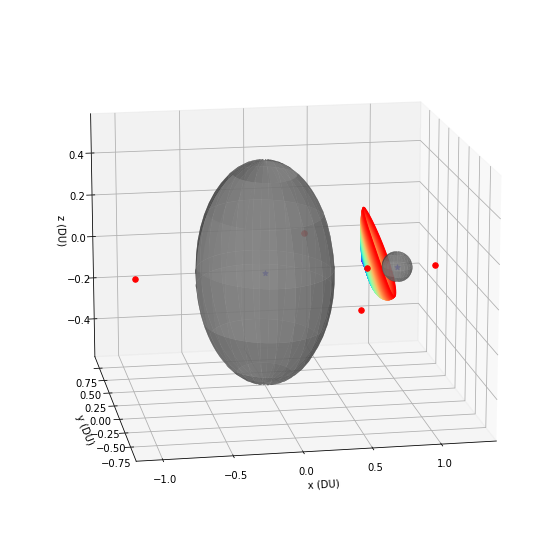

In [11]:
colors = plt.cm.rainbow(np.linspace(0, 1, len(halo_family)))
icolor = 0

ax, fig = r3bpy.visu.init_figure(False)
for halo_orbit in halo_family:
    ax = plot_halo(halo_orbit, colors[icolor], ax)
    icolor = icolor + 1        

plot_system(problem, is2d=False, ax=ax)
plot_binary_system(ax, mu_ratio)
ax.view_init(elev=15., azim=260)

So, it seems the Halo orbit could be quite interesting, but bear in mind that there are several operational constraints that we do not take into account, such as:
- communication with the ground segment (Earth), 
- direct link with it for navigation purposes.
- sun direction and illuminated faces

We will elaborate further on some of these points in the following sections.

## Manifolds

We now construct manifolts departing from this orbit.

In [12]:
halo_orbit = halo_family[0] # choose one Halo of the family
print('Halo period: {} h'.format(halo_orbit.period * TU / 3600.))
print('Orbit amplitudes: ', halo_orbit.Ax, halo_orbit.Ay, halo_orbit.Az)

_, xyz_halo = halo_orbit.propagate([0, halo_orbit.period])

Halo period: 5.746603508236295e-05 h
Orbit amplitudes:  0.021369635099567078 0.0 0.027559055118110236


In [13]:
manifolds = Manifold(halo_orbit)
stable_vector_space = manifolds.get_stableManifold_basis()
unstable_vector_space = manifolds.get_unstableManifold_basis()
center_vector_space = manifolds.get_centerManifold_basis()

We can now plot again the previous binary system with the stable and unstable manifolds (when they exist).

In [14]:
stable_vector_space, unstable_vector_space, center_vector_space

([array([-0.29232608-0.01381334j, -0.09419199-0.00445087j,
          0.00627462+0.0002965j ,  0.88598715+0.04186572j,
          0.3409256 +0.01610982j, -0.04693158-0.00221767j]),
  array([-0.02194343-0.05470568j,  0.47312521-0.18977897j,
         -0.17766921-0.44293517j,  0.40172589-0.16113943j,
          0.16176627+0.40328862j,  0.33815205-0.13563882j]),
  array([ 0.05600524+0.01837494j,  0.15891672-0.48436453j,
          0.45345732+0.14877627j,  0.1349346 -0.41126908j,
         -0.41286894-0.1354595j ,  0.11358095-0.34618501j])],
 [array([ 0.29265226-1.23191135e-05j, -0.09429709+3.96940928e-06j,
         -0.00628162+2.64423033e-07j,  0.88697575-3.73369916e-05j,
         -0.34130601+1.43671792e-05j, -0.04698394+1.97777578e-06j])],
 [array([ 3.88944266e-07+1.43675168e-07j,  2.30884687e-01-6.25031937e-01j,
         -1.84266256e-05-6.80675618e-06j,  1.88711517e-01-5.10864217e-01j,
         -1.36175179e-05-5.03028093e-06j, -1.76493888e-01+4.77789662e-01j]),
  array([ 1.36937893e-07+3.9136

We can now plot again the previous binary system with the stable and unstable manifolds (when they exist).

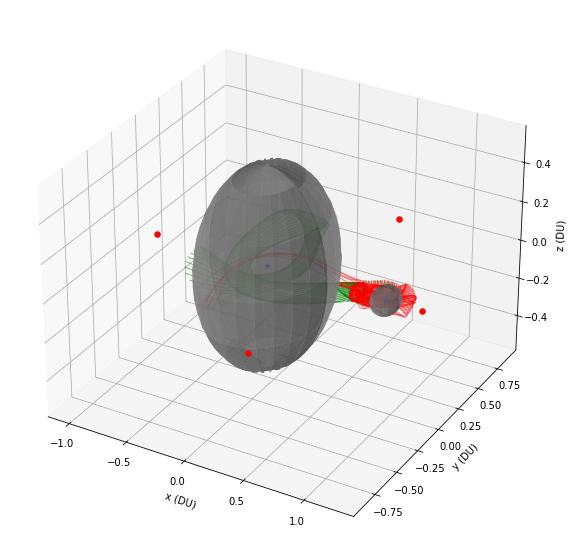

In [15]:
from r3bpy.visu import plot_system, plot_manifold, plot_trajectory

ax = plot_system(problem, is2d=False)
plot_trajectory(xyz_halo, ax=ax)
if stable_vector_space:
    plot_manifold(mu_ratio, xyz_halo, orbit_period, stable_vector_space[0], max_duration=-4, displace=0.01, color='g', ax=ax)
    plot_manifold(mu_ratio, xyz_halo, orbit_period, stable_vector_space[0], max_duration=4, displace=-0.01, color='g', ax=ax)
if unstable_vector_space:
    plot_manifold(mu_ratio, xyz_halo, orbit_period, unstable_vector_space[0], max_duration=4, displace=0.01, color='r', ax=ax)
    plot_manifold(mu_ratio, xyz_halo, orbit_period, unstable_vector_space[0], max_duration=-4, displace=-0.01, color='r', ax=ax)
plot_binary_system(ax, mu_ratio) 
plt.show()

The size of the primary P1, make the use of a part of the manifold infeasible. Going from L1, to L2 or L3 will most likely demand a bit of manoeuvering!

## Mission around the asteroids

We will now assess the global coverage of both asteroids.

Let's select one of the Halo of the family. 

Its trajectory is given by,

In [16]:
halo_orbit = halo_family[0] # choose one Halo of the family
print_info(halo_orbit)

_, xyz_halo = halo_orbit.propagate([0, halo_orbit.period])
xyz_halo = np.array(xyz_halo)

Orbit type           : halo
      period         : 2.549109
      Libration Point: L0
      Primaries      :  


(<r3bpy.visu.plot_object.Ellipsoid at 0x7f5fb2a4f700>,
 <r3bpy.visu.plot_object.Ellipsoid at 0x7f5fb120da00>)

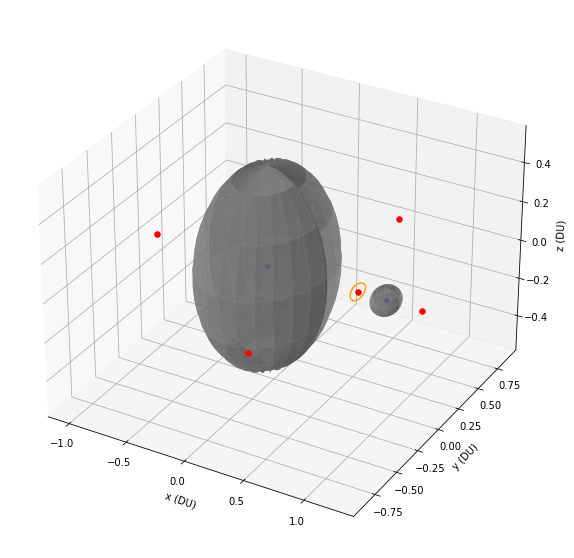

In [17]:
ax, fig = r3bpy.visu.init_figure(False)
ax = plot_halo(halo_orbit, 'orange', ax=ax)
plot_system(problem, is2d=False, ax=ax)
plot_binary_system(ax, mu_ratio)

To compute any ground related metrics, the Halo trajectory shall be given in the asteroid orbiting frame. However, for now we assume that the asteroid rotate at the same angular velocity as the RTBP such that its motion in the RTBP appears fixed.

For each point along the Halo orbit, and each facelet of the asteroid shapes, we estimate the minimum aspect angle.

In [18]:
def angle(normal, direction):
    cosv = np.dot(normal / np.linalg.norm(normal), direction / np.linalg.norm(direction))
    return np.arccos(cosv)

In [19]:
e1, e2 = plot_binary_system(None, mu_ratio)

e1_faces = e1.get_faces()  

r1 = [-mu_ratio, 0, 0]
r2 = [1-mu_ratio, 0, 0]
a = [0.] * len(e1_faces)
a = np.empty((len(e1_faces), len(e1_faces[0])))
v = np.array([0.]*len(xyz_halo))
for iface in range(0, len(e1_faces)):
    for jface in range(0, len(e1_faces[0])):
        face = e1_faces[iface][jface]    
        face_center = face.get_center()
        e1_face_normal = face.get_normal()
    
        for i in range(0, len(xyz_halo)):
            p = xyz_halo[i, 0:3]            
            v[i] = angle(e1_face_normal, p - face_center)    

        a[iface,jface] = np.min(v)     

Let's plot the result

In [20]:
def f(x):
    return np.int(x)
f2 = np.vectorize(f)

def float_to_rgb(x, colors):
    """ Convert a float to a tuple of floats between 0 and 1 for R, G, and B. """    
    idx = [f2(np.floor(a * (len(colors)-1))) for a in x]
    return colors[idx,:]

/tmp/ipykernel_27353/3831300318.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.int(x)


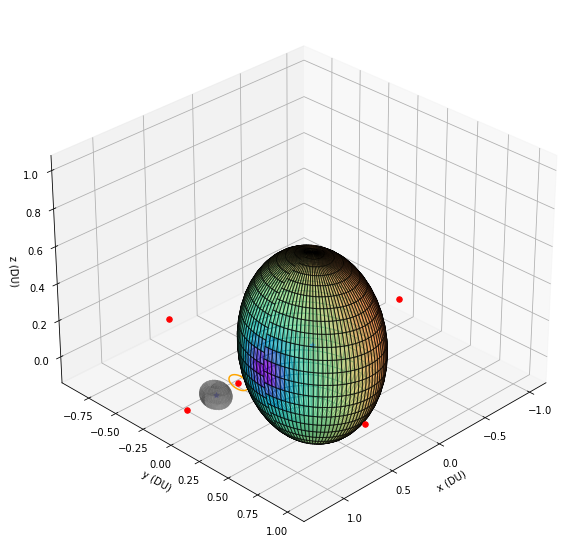

In [21]:
from matplotlib.colors import ColorConverter
colors = plt.cm.rainbow(np.linspace(0, 1, len(a)))

ax, fig = r3bpy.visu.init_figure(False)
#e1.plot(ax,color='grey') 

anormalized = (a - np.min(a)) / (np.max(a) - np.min(a))
fc = float_to_rgb(anormalized, colors)
for iface in range(0, len(e1_faces)):
    for jface in range(0, len(e1_faces[0])):
        face = e1_faces[iface][jface] 
        face.plot(ax, color=fc[iface][jface]) 

e2.plot(ax,color='grey')        
ax = plot_halo(halo_orbit, 'orange', ax=ax)
plot_system(problem, is2d=False, ax=ax)

#ax.set_xlim([0.7, 1.2])
#ax.set_ylim([-0.2, 0.2])
#ax.set_zlim([-0.1, 0.1])        
ax.view_init(azim=45)

Text(0, 0.5, 'lat, deg')

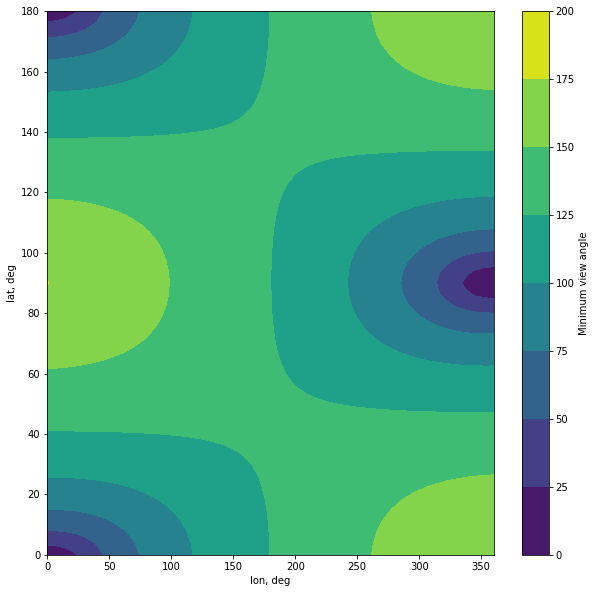

In [22]:
ax = plt.axes()
n = len(e1_faces)
m = len(e1_faces[0])
x = np.linspace(0, 360, n)
y = np.linspace(0, 180, m)
c = ax.contourf(x, y, np.rad2deg(a.T))
cbar = plt.colorbar(c)
cbar.set_label('Minimum view angle')
ax.set_xlabel('lon, deg')
ax.set_ylabel('lat, deg')